In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: incomplete input (3123407198.py, line 17)

In [89]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

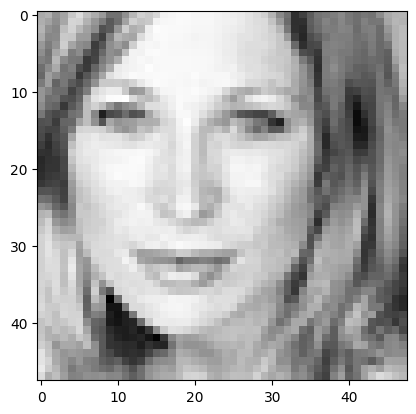

In [90]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

img = plt.imread('/kaggle/input/fer2013/train/happy/Training_95673040.jpg')
plt.imshow(img, cmap='gray')

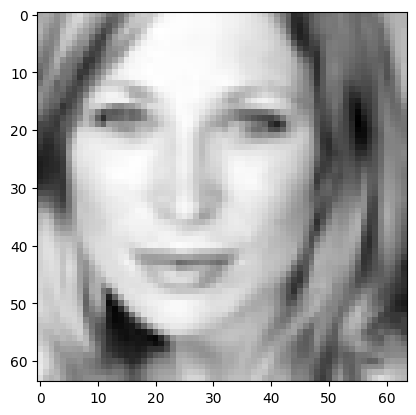

In [91]:
img_resize = cv2.resize(img, (64, 64))
plt.imshow(img_resize, cmap='gray')

In [92]:
train_transform = transforms.Compose([
    # transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
    # transforms.RandomCrop(48, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Test set transformations without data augmentation
test_transform = transforms.Compose([
    # transforms.Resize(224),
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Same normalization as train set
])

In [93]:
train_dataset = datasets.ImageFolder('/kaggle/input/fer2013/train', transform=train_transform)
test_dataset = datasets.ImageFolder('/kaggle/input/fer2013/test', transform=test_transform)

In [94]:
train_dataset.classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [95]:
train_dataset.class_to_idx

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [96]:
type(train_dataset)

torchvision.datasets.folder.ImageFolder

In [97]:
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True, num_workers=4)

In [98]:
type(train_dataloader)

torch.utils.data.dataloader.DataLoader

In [99]:
img, label = next(iter(train_dataloader))

In [100]:
img.shape

torch.Size([20, 3, 48, 48])

In [101]:
label

tensor([2, 3, 5, 3, 2, 6, 0, 3, 3, 4, 3, 5, 3, 3, 4, 4, 1, 4, 3, 3])

3


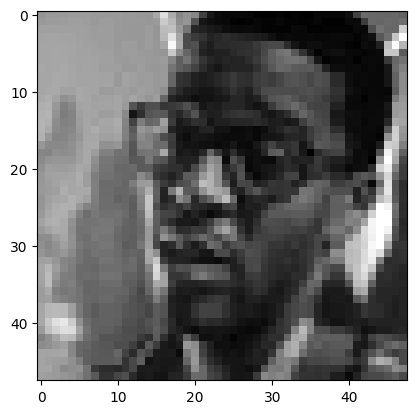

In [102]:
plt.imshow(img[10].numpy().transpose(1, 2, 0))
print(label[10].item())

In [103]:
# model = models.vgg16(pretrained=True)

In [104]:
# for param in model.parameters():
#     param.required_grad = False
#     # print(param)

In [105]:
# model

In [106]:
# num_of_inputs = model.classifier[0].in_features
# num_of_inputs

In [107]:
# model.classifier

In [108]:
# # restructaring the classifier
# import torch.nn as nn
# model.classifier = nn.Sequential(
#                       nn.Linear(num_of_inputs, 7),
#                         nn.LogSoftmax(dim=1))

In [109]:
# model

In [110]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(CustomCNN, self).__init__()

        # First Convolutional Block (Conv -> ReLU -> MaxPool)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)  # Add BatchNorm
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)

        # Third Convolutional Block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)

        # Fourth Convolutional Block
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(256)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 3 * 3, 512)  # Flattened size after convolutions
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        # Dropout (helps prevent overfitting)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Forward pass through the convolutional layers
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))  # 1st Conv Block
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))  # 2nd Conv Block
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))  # 3rd Conv Block
        x = self.pool(F.relu(self.conv4_bn(self.conv4(x))))  # 4th Conv Block

        # Flatten the tensor for fully connected layers
        x = x.view(-1, 256 * 3 * 3)  # Adjust according to the final shape after pooling

        # Forward pass through the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Dropout
        x = self.fc3(x)  # Output layer

        return x

# Example of how to instantiate the model
model = CustomCNN(num_classes=7)

In [111]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [112]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

CUDA is available!  Training on GPU ...


In [113]:
# loss function and optimizer
# criterion = nn.NLLLoss()
# optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [114]:
from torch.autograd import Variable

In [115]:
# number of epochs to train the model
n_epochs = 50
loss_array = []
accuracy_array = []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    train_accuracy = 0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_dataloader:
        if train_on_gpu:
            data, target = Variable(data.cuda()), Variable(target.cuda())
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        #calculate accuracy
        ps = torch.exp(output)
        
        top_p, top_class = ps.topk(1, dim=1)
        # print(top_class)
        equals = top_class == target.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
# calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    loss_array.append(train_loss)
    accuracy_array.append(round(train_accuracy/len(train_dataloader),3))

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch+1, 
            train_loss
            ))
    print(f"Train accuracy: {train_accuracy/len(train_dataloader):.3f}")

Epoch: 1 	Training Loss: 1.718682
Train accuracy: 0.301
Epoch: 2 	Training Loss: 1.471751
Train accuracy: 0.430
Epoch: 3 	Training Loss: 1.371266
Train accuracy: 0.477
Epoch: 4 	Training Loss: 1.301171
Train accuracy: 0.505
Epoch: 5 	Training Loss: 1.257299
Train accuracy: 0.526
Epoch: 6 	Training Loss: 1.221659
Train accuracy: 0.536
Epoch: 7 	Training Loss: 1.182571
Train accuracy: 0.556
Epoch: 8 	Training Loss: 1.159686
Train accuracy: 0.565
Epoch: 9 	Training Loss: 1.135820
Train accuracy: 0.571
Epoch: 10 	Training Loss: 1.113126
Train accuracy: 0.583
Epoch: 11 	Training Loss: 1.092655
Train accuracy: 0.591
Epoch: 12 	Training Loss: 1.077509
Train accuracy: 0.597
Epoch: 13 	Training Loss: 1.056028
Train accuracy: 0.604
Epoch: 14 	Training Loss: 1.041532
Train accuracy: 0.611
Epoch: 15 	Training Loss: 1.021875
Train accuracy: 0.619
Epoch: 16 	Training Loss: 1.002687
Train accuracy: 0.622
Epoch: 17 	Training Loss: 0.992277
Train accuracy: 0.631
Epoch: 18 	Training Loss: 0.971495
Train

In [117]:
[i for i in range(n_epochs)]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

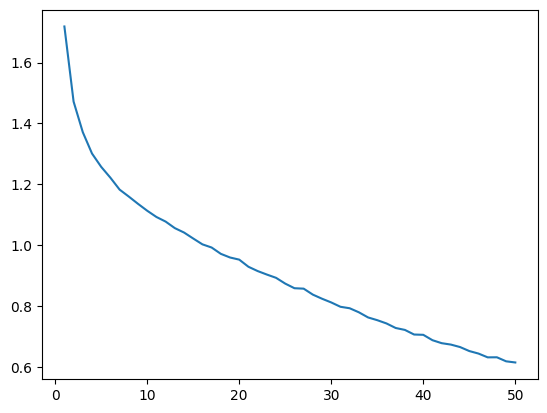

In [118]:
import matplotlib.pyplot as plt

plt.plot([i+1 for i in range(n_epochs)], loss_array)

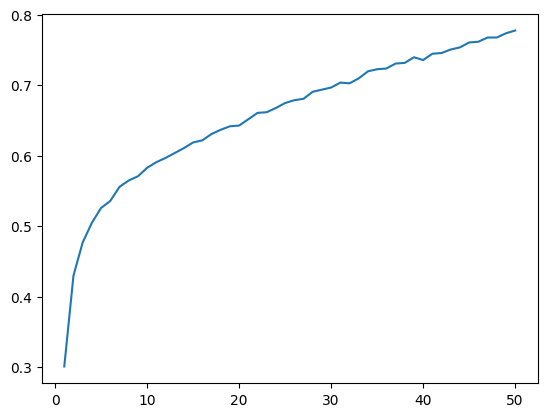

In [119]:
plt.plot([i+1 for i in range(n_epochs)], accuracy_array)

In [122]:
test_accuracy = 0
model.eval() # prep model for evaluation
for data, target in test_dataloader:
    if train_on_gpu:
        data, target = Variable(data.cuda()), Variable(target.cuda())
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    #calculate accuracy
    ps = torch.exp(output)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == target.view(*top_class.shape)
    test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test accuracy: {test_accuracy/len(test_dataloader):.3f}")

Test accuracy: 0.626
